In [ ]:
# Uncomment the line below to install Aer package for custom depolarizing error
# !pip install qiskit-aer

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
import numpy as np
from qiskit.providers.fake_provider import FakeProvider
from qiskit.circuit.library import CZGate, RXGate, RYGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, depolarizing_error

In [2]:
# Define the gates
X90 = RXGate(np.pi / 2)
Y90 = RYGate(np.pi / 2)
T = TGate()
X = XGate()
Y = YGate()
SW = UnitaryGate((np.sqrt((X.to_matrix() + Y.to_matrix())/np.sqrt(2))), label='SW')
XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
CZ = CZGate()
CP = CPhaseGate(np.pi/2)
# Possible gate sets
gate_dict1 = {0: X90, 1: Y90, 2: T}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90, 1: Y90, 2: SW}  # Supremacy gate set
gate_dict3 = {0: X90, 1: Y90, 2: XY90, 3: XY90mm, 4: XY90pm, 5: XY90mp} # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90, 1: Y90, 2: XY90}
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]

# Choose the gate set
gate_set_choice = 4 # 1, 2, or 3
gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)

In [6]:
(X90.to_matrix() + Y90.to_matrix())

array([[ 1.41421356+0.j        , -0.70710678-0.70710678j],
       [ 0.70710678-0.70710678j,  1.41421356+0.j        ]])

In [51]:
# depol_error = depolarizing_error(0.005, 2)
# noise_model = NoiseModel()
# noise_model.add_all_qubit_quantum_error(depol_error, ["cz"])
# backend = AerSimulator(noise_model=noise_model)
backend = FakeProvider().get_backend("fake_valencia")

In [52]:
# np.random.seed(335)
sequences = 10
max_depth = 200
depths = np.arange(2, max_depth + 1, 9)
n_avgs = 1000

qubits = QuantumRegister(2, "q")

sq_gates = []  # 2D for 2 qubits
counts_list = []
states_list = []  # Store the statevectors
circuits_list = []  # Store the circuits

# Generate sequences
for s in range(sequences):  # For each sequence
    counts_list.append([])
    sq_gates.append([])
    circuits_list.append([])
    states_list.append([])
    for i, d in enumerate(depths):  # For each depth
        sq_gates[s].append(np.zeros((2, d), dtype=int))
        for q in range(2):  # For each qubit
            # Generate random single qubit gates
            # Start the sequence with a random gate
            sq_gates[s][i][q][0] = np.random.randint(random_gates)
        for d_ in range(1, d):  # Loop over the rest of the sequence
            for q in range(2):  # For each qubit
                sq_gates[s][i][q][d_] = np.random.randint(random_gates)
                # Make sure that the same gate is not applied twice in a row
                while sq_gates[s][i][q][d_] == sq_gates[s][i][q][d_ - 1]:
                    sq_gates[s][i][q][d_] = np.random.randint(random_gates)
        # Define the circuit
        qc = QuantumCircuit(qubits)
        for d_ in range(d):  # Apply layers
            for q in range(2):  # For each qubit, append single qubit gates
                qc.append(gate_dict[sq_gates[s][i][q][d_]], [qubits[q]])
            # Apply CZ gate
            qc.append(CZ, qubits)
        # Store the statevector
        states_list[s].append(Statevector(qc))
        circuits_list[s].append(qc)
        # Measure the circuit
        

In [55]:
depths

array([  2,  11,  20,  29,  38,  47,  56,  65,  74,  83,  92, 101, 110,
       119, 128, 137, 146, 155, 164, 173, 182, 191, 200])

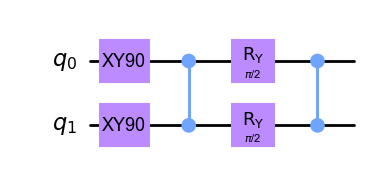

In [57]:
circuits_list[1][0].draw(output="mpl", style='clifford')

In [58]:
for s in range(sequences):
    for i, d in enumerate(depths):
        qc2 = transpile(circuits_list[s][i].measure_all(inplace=False), backend)
        job = backend.run(qc2, shots=n_avgs)
        counts = job.result().get_counts()

        # Add missing keys to counts
        for key in [bin(i)[2:].zfill(2) for i in range(2 ** len(qubits))]:
            if key not in counts.keys():
                counts[key] = 0
        # Add counts to list
        counts_list[s].append(counts)
        

In [63]:
states_list[0][1].probabilities()

array([0.31961591, 0.25308642, 0.22290809, 0.20438957])

In [61]:
counts_list[1][3]

{'10': 85, '11': 111, '00': 196, '01': 608}

In [64]:
def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

recomputed [5.00000000e-01 1.99347457e-32 1.80117038e-32 5.00000000e-01]
state based [5.00000000e-01 1.99347457e-32 1.80117038e-32 5.00000000e-01]
measured [0.48  0.037 0.027 0.456]
seq 1, depth 2: f_xeb = 0.8719999999999999
recomputed [0.31961591 0.25308642 0.22290809 0.20438957]
state based [0.31961591 0.25308642 0.22290809 0.20438957]
measured [0.333 0.232 0.259 0.176]
seq 1, depth 11: f_xeb = 1.1565505133415463
recomputed [0.33125157 0.12773447 0.43109615 0.10991781]
state based [0.33125157 0.12773447 0.43109615 0.10991781]
measured [0.369 0.144 0.359 0.128]
seq 1, depth 20: f_xeb = 0.8292051667368849
recomputed [0.3358369  0.04990206 0.52407605 0.09018499]
state based [0.3358369  0.04990206 0.52407605 0.09018499]
measured [0.339 0.12  0.425 0.116]
seq 1, depth 29: f_xeb = 0.7033616247920351
recomputed [0.3206874  0.44293052 0.17460921 0.06177287]
state based [0.3206874  0.44293052 0.17460921 0.06177287]
measured [0.345 0.35  0.182 0.123]
seq 1, depth 38: f_xeb = 0.67632092623695
r

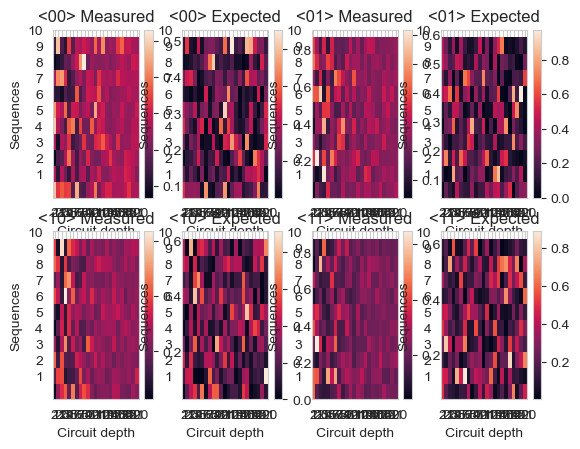

In [65]:
from scipy.optimize import curve_fit

# Calculate the XEB fidelity
records = []
incoherent_dist = 0.25 * np.ones(4)
fidelities = np.zeros((sequences, len(depths)))
expected_probs = np.zeros((sequences, len(depths), 2 ** len(qubits)))
measured_probs = np.zeros((sequences, len(depths), 2 ** len(qubits)))

for s in range(sequences):
    for j, d in enumerate(depths):
        state = Statevector.from_int(0, 2 ** len(qubits))
        for k in range(d):
            sq_gate1, sq_gate2 = (
                gate_dict[sq_gates[s][j][0][k]],
                gate_dict[sq_gates[s][j][1][k]],
            )
            # Retrieve random single qubit gates applied on both qubits
            # Apply the gates on the state
            state = state.evolve(sq_gate1, [0])
            state = state.evolve(sq_gate2, [1])
            state = state.evolve(CZ, [0, 1])
            # print("computed state: %s" % state)
        expected_probs[s, j] = state.probabilities()
        print("recomputed", expected_probs[s, j])
        print("state based", states_list[s][j].probabilities())
        measured_probs[s, j] = (
            np.array([counts_list[s][j][bit] for bit in ["00", "01", "10", "11"]])
            / n_avgs
        )
        print("measured", measured_probs[s, j])
        xe_incoherent = cross_entropy(incoherent_dist, expected_probs[s, j])
        xe_measured = cross_entropy(measured_probs[s, j], expected_probs[s, j])
        xe_expected = cross_entropy(expected_probs[s, j], expected_probs[s, j])

        f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
        fidelities[s, j] = f_xeb
        print(f"seq {s + 1}, depth {depths[j]}: f_xeb = {f_xeb}")
        records += [
            {
                "sequence": s,
                "depth": depths[j],
                "pure_probs": expected_probs[s, j],
                "sampled_probs": measured_probs[s, j],
                "circuit": circuits_list[s][j],
            }
        ]

for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / 2 ** len(qubits)
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)


# Plot the results
def create_subplot(data, subplot_number, title):
    print(title)
    # print("data: %s" % data)
    print(subplot_number)
    plt.subplot(subplot_number)
    plt.pcolor(depths, range(sequences), np.abs(data))
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Circuit depth")
    ax.set_ylabel("Sequences")
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, sequences + 1))
    plt.colorbar()


# titles = ["q1 measured", "q2 measured", f'q{qubits[0]}-I', f'q{qubits[1]}-I']
titles = []
for i in range(4):
    titles.append(f"<{bin(i)[2:].zfill(2)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(2)}> Expected")

# data = [S1, S2, I1, I2]
data = []
for i in range(4):
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]
print(measured_probs.shape)
# plt.suptitle(f"XEB for q{qubits[0]}-q{qubits[1]}, inner-average: {n_avgs}, random-gates: {3}")
for title, d, n in zip(titles, data, plot_number):
    create_subplot(d, n, title)

plt.show()

In [66]:
import pandas as pd

df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df.head()

,sequence,depth,pure_probs,sampled_probs,circuit,e_u,u_u,m_u,y,x,numerator,denominator
0,0,2,"[0.4999999999999999, 1.9934745664467748e-32, 1...","[0.48, 0.037, 0.027, 0.456]","((Instruction(name='rx', num_qubits=1, num_clb...",0.500000,0.25,0.468000,0.218000,0.250000,0.054500,0.062500
1,0,11,"[0.3196159122085052, 0.25308641975308666, 0.22...","[0.333, 0.232, 0.259, 0.176]","((Instruction(name='unitary', num_qubits=1, nu...",0.257670,0.25,0.258854,0.008854,0.007670,0.000068,0.000059
2,0,20,"[0.331251571983846, 0.1277344678587718, 0.4310...","[0.369, 0.144, 0.359, 0.128]","((Instruction(name='unitary', num_qubits=1, nu...",0.323970,0.25,0.309459,0.059459,0.073970,0.004398,0.005471
3,0,29,"[0.33583690381434705, 0.049902058742174835, 0....","[0.339, 0.12, 0.425, 0.116]","((Instruction(name='ry', num_qubits=1, num_clb...",0.398066,0.25,0.353031,0.103031,0.148066,0.015255,0.021923
4,0,38,"[0.32068739663527857, 0.44293051528122573, 0.1...","[0.345, 0.35, 0.182, 0.123]","((Instruction(name='ry', num_qubits=1, num_clb...",0.333332,0.25,0.305040,0.055040,0.083332,0.004587,0.006944


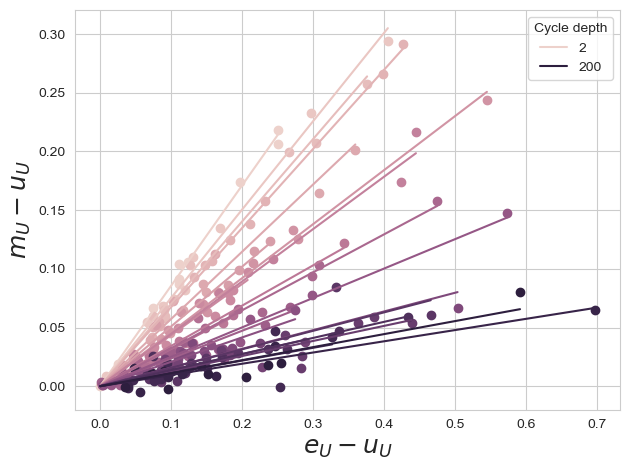

In [67]:
%matplotlib inline
from matplotlib import pyplot as plt

# Color by cycle depth
import seaborn as sns

colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.tight_layout()

/var/folders/y8/9zgwllj55dbbch4pxmg_g7jm0000gn/T/ipykernel_8413/3759073369.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


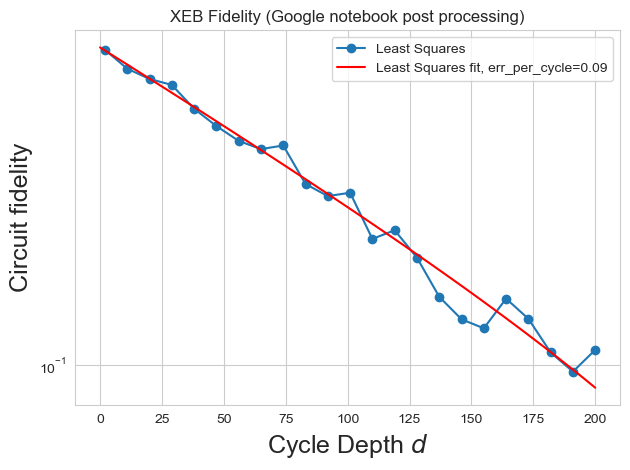

In [68]:
plt.plot(fids["depth"], fids["fidelity"], marker="o", label="Least Squares")
xx = np.linspace(0, fids["depth"].max())


def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c


# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    params, covariance = curve_fit(exponential_decay, depths, fids["fidelity"])
    a_fit, b_fit, c_fit = params
    x = exponential_decay(depths, a_fit, b_fit, c_fit)
    xeb_err_per_cycle = 1 - (x[2] - c_fit) / (x[1] - c_fit)
except:
    pass

# The additional factor of four in the exponent is because each layer
# involves two moments of two qubits (so each layer has four applications
# of a single-qubit single-moment depolarizing channel).
plt.plot(xx, exponential_decay(xx, a_fit, b_fit, c_fit),
         label='Least Squares fit, err_per_cycle={:.2f}'.format(xeb_err_per_cycle),
         color='red')

plt.ylabel("Circuit fidelity", fontsize=18)
plt.xlabel("Cycle Depth $d$", fontsize=18)
plt.title("XEB Fidelity (Google notebook post processing)")
plt.legend(loc="best")
plt.yscale("log")
plt.tight_layout()

/var/folders/y8/9zgwllj55dbbch4pxmg_g7jm0000gn/T/ipykernel_8413/3759073369.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


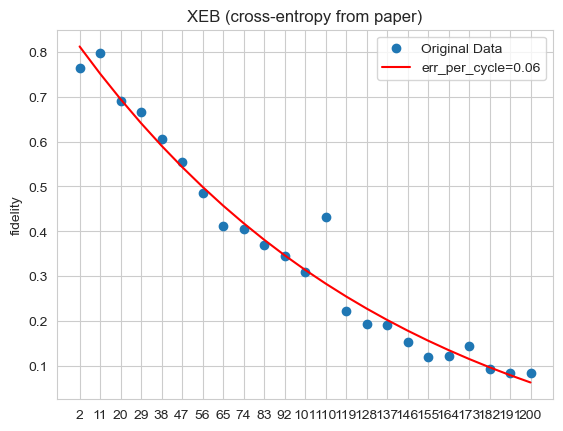

In [69]:

Fxeb = np.mean(fidelities, axis=0)
# print(Fxeb)

try:
    params, covariance = curve_fit(exponential_decay, depths, Fxeb)
    a_fit, b_fit, c_fit = params
    x = exponential_decay(depths, a_fit, b_fit, c_fit)
    xeb_err_per_cycle = 1 - (x[2] - c_fit) / (x[1] - c_fit)
except:
    pass

plt.scatter(depths, Fxeb, label="Original Data")
plt.plot(
    depths,
    exponential_decay(depths, a_fit, b_fit, c_fit),
    label="err_per_cycle={:.2f}".format(xeb_err_per_cycle),
    color="red",
)
plt.legend()
plt.title("XEB (cross-entropy from paper)")
plt.ylabel("fidelity")
plt.xticks(depths)
plt.show()

In [70]:
fids["fidelity"] # Google processing

0     0.856470
1     0.753292
2     0.702522
3     0.674582
4     0.573443
5     0.509779
6     0.460689
7     0.435755
8     0.446629
9     0.343509
10    0.316418
11    0.323755
12    0.236338
13    0.250805
14    0.207998
15    0.159362
16    0.136738
17    0.128589
18    0.157394
19    0.137204
20    0.109105
21    0.095732
22    0.111040
Name: fidelity, dtype: float64

In [71]:
Fxeb # Derived from the paper

array([0.76390794, 0.79627216, 0.6901503 , 0.66682464, 0.60512845,
       0.55388931, 0.48559435, 0.4125941 , 0.40446911, 0.37008482,
       0.34590991, 0.30983869, 0.43214071, 0.22241438, 0.19345295,
       0.19034976, 0.15252821, 0.1193641 , 0.12288634, 0.14534635,
       0.09277729, 0.08428084, 0.08337581])